In [1]:
    """
Pidgin is a literate computing implementation in IPython.  It allows authors to compose their source in the markup language of their choice (e.g. Markdown, RST, Latex).  Narrative, source code, and documentation tests are composed together.

    """

'\nPidgin is a literate computing implementation in IPython.  It allows authors to compose their source in the markup language of their choice (e.g. Markdown, RST, Latex).  Narrative, source code, and documentation tests are composed together.\n\n'

In [2]:
    __all__ = 'Pidgin',

In [3]:
    _run_as_main =  __name__ == '__main__'
    _run_as_script = _run_as_main and globals().get('__file__', None) in __import__('sys').argv
    _run_as_interactive = _run_as_main and not _run_as_script    

In [4]:
    import ast, textwrap, re, doctest, functools, collections, contextlib, sys
    import pandocfilters, traitlets, IPython, nbconvert, jinja2.meta, jinja2.ext
    import importnb, ipykernel, htmlmin
    
    get_ipython = IPython.get_ipython
    shell = get_ipython()

    pidgin=\
    10 and _run_as_interactive and __import__('pidgin').load()

import ast, textwrap, re, doctest, functools, collections, contextlib, sys
    import pandocfilters, traitlets, IPython, nbconvert, jinja2.meta, jinja2.ext
    import importnb, ipykernel, htmlmin
    
    get_ipython = IPython.get_ipython
    shell = get_ipython()

    pidgin=\
    10 and _run_as_interactive and __import__('pidgin').load()

In [5]:
    input_formats = !pandoc --list-input-formats
    output_formats = !pandoc --list-output-formats    

    def translate(source=None, input='markdown', target='rst', file=None, args='', *, lang='ipython'):
        if callable(target): return target(source)
        import json, subprocess
        process = subprocess.Popen(['pandoc', f'--read={input}', f'--write={target}', *F"--indented-code-classes={lang} {args}".rstrip().split()], stdin=subprocess.PIPE, stdout=subprocess.PIPE)
        returns = process.communicate(source.encode())[0].decode()
        if target in {'json'}: return json.loads(returns)
        return returns

input_formats = !pandoc --list-input-formats
    output_formats = !pandoc --list-output-formats    

    def translate(source=None, input='markdown', target='rst', file=None, args='', *, lang='ipython'):
        if callable(target): return target(source)
        import json, subprocess
        process = subprocess.Popen(['pandoc', f'--read={input}', f'--write={target}', *F"--indented-code-classes={lang} {args}".rstrip().split()], stdin=subprocess.PIPE, stdout=subprocess.PIPE)
        returns = process.communicate(source.encode())[0].decode()
        if target in {'json'}: return json.loads(returns)
        return returns

In [6]:
    def python(source, input='markdown'):
        if should_not_transform_source(source): return source
        def action(type, value, format, metadata):
            nonlocal code, remaining, min_indent
            if type == 'CodeBlock':
                if (''.join(value[0][1]) or 'ipython') == 'ipython' and (
                    not value[1].lstrip().startswith('>>>')
                ):
                    splitter = re.compile(''.join("\\s{0,4}%s\\s*"%re.escape(x) for x in value[1].splitlines() if x.strip()))

                    try: before, after = re.split(splitter, remaining, 1)
                    except:  before = after = ''
                    current = len(after) and remaining[len(before):-len(after)] or remaining[len(before):]
                    if current.lstrip().startswith('```'): return
                    remaining = after

                    # Extract the first line of the current code block.
                    first_line = get_first_line(current)
                    # Construct the code we'll 
                    current, body = ''.join(current), ''.join(before)

                    # The previous last line append
                    last_line = get_last_line(code.splitlines())

                    if not last_line.endswith(('"'*3, "'"*3, '-'*3, '"'*3+"\\", "'"*3+'\\',)): body = quote(body, '')

                    definition = last_line.rstrip().endswith(':')

                    this_indent = get_line_indent(first_line)                  
                    min_indent = min_indent or this_indent

                    # The current indent level so far.
                    prior_indent = get_line_indent(last_line) or min_indent

                    if this_indent < min_indent:
                        current = textwrap.indent(current, ' '*(min_indent-this_indent))
                        this_indent = get_line_indent(get_first_line(current.splitlines()))

                    indent = max(min_indent, (has_return(code) and min or max)(prior_indent, this_indent))        
                    if definition:
                        if prior_indent >= indent: indent = (prior_indent + 4)
                        body = hanging_indent(textwrap.indent(body, ' '*min_indent), ' '*(indent-min_indent))
                    else: body = textwrap.indent(body, ' '*indent)

                    code += body+current
                    
        remaining, code, min_indent = source, """""", 0
        pandocfilters.walk(translate(source, input, 'json'), action, 'python', {})
        if remaining.strip(): code += textwrap.indent(quote(remaining), ' '*min_indent).rstrip() + ';'
        return textwrap.dedent(code)

    def remove_doctest_cleanup(input_transformer_manager):  
        for i, transformer in enumerate(input_transformer_manager.cleanup_transforms):
            try:
                if transformer.initial_re.pattern[1:4] == '>>>': input_transformer_manager.cleanup_transforms.pop(i); break
            except: ...

    def quote(str: str, punc: str='') -> str:
        str, leading_ws = ''.join(str), []
        lines = str.splitlines(True)
        _ = '"'*3
        if _ in str: _ = "'"*3 # it seems quotes are a problem
        if not str.strip(): _ = punc = ''
        while lines and (not lines[0].strip()): leading_ws.append(lines.pop(0))    
        str = ''.join(lines)
        end = len(str.rstrip())
        str, ending_ws = str[:end], str[end:]
        if str and str.endswith(_[0]): str += ' '                    
        return F"{''.join(leading_ws)}{_}{str}{_}{punc}{ending_ws}"

    def get_first_line(lines: (str, list), line: str='') -> str:
        if not isinstance(lines, (reversed, list)): lines = lines.splitlines()
        for line in lines or ['']: 
            if line.strip(): break
        return line

    def get_last_line(lines, line=''): return get_first_line(lines[::-1], line)

    def get_line_indent(line: str) -> int:   return len(line) - len(line.lstrip())

    def has_return(code: str) -> bool:
        code = '\n'.join(code)
        if 'return ' not in code: return False
        code = importnb.loader.dedent(code)
        try:
            node = ast.parse(code)
            while hasattr(node, 'body'): node = node.body[-1]
            return isinstance(node, ast.Return)
        except: ...

    def hanging_indent(str, indent: str, *, out="""""") -> str:
        for line in str.splitlines(True):
            if not line.strip(): out += line
            else:
                if out.strip(): out += line
                else: out += indent+line
        return out
    
    def strip_blank_lines(str): return '\n'.join(str if str.strip() else '' for str in ''.join(str).splitlines())

    def should_not_transform_source(str): return str.startswith('%%')    

def python(source, input='markdown'):
        if should_not_transform_source(source): return source
        def action(type, value, format, metadata):
            nonlocal code, remaining, min_indent
            if type == 'CodeBlock':
                if (''.join(value[0][1]) or 'ipython') == 'ipython' and (
                    not value[1].lstrip().startswith('>>>')
                ):
                    splitter = re.compile(''.join("\\s{0,4}%s\\s*"%re.escape(x) for x in value[1].splitlines() if x.strip()))

                    try: before, after = re.split(splitter, remaining, 1)
                    except:  before = after = ''
                    current = len(after) and remaining[len(before):-len(after)] or remaining[len(before):]
                    if current.lstrip().startswith('```'): return
                    remaining = after

                    # Extract the first line of the current code block.
                    first_line = get_first_line(current)
                    # Construct the code we'll 
                    current, body = ''.join(current), ''.join(before)

                    # The previous last line append
                    last_line = get_last_line(code.splitlines())

                    if not last_line.endswith(('"'*3, "'"*3, '-'*3, '"'*3+"\\", "'"*3+'\\',)): body = quote(body, '')

                    definition = last_line.rstrip().endswith(':')

                    this_indent = get_line_indent(first_line)                  
                    min_indent = min_indent or this_indent

                    # The current indent level so far.
                    prior_indent = get_line_indent(last_line) or min_indent

                    if this_indent < min_indent:
                        current = textwrap.indent(current, ' '*(min_indent-this_indent))
                        this_indent = get_line_indent(get_first_line(current.splitlines()))

                    indent = max(min_indent, (has_return(code) and min or max)(prior_indent, this_indent))        
                    if definition:
                        if prior_indent >= indent: indent = (prior_indent + 4)
                        body = hanging_indent(textwrap.indent(body, ' '*min_indent), ' '*(indent-min_indent))
                    else: body = textwrap.indent(body, ' '*indent)

                    code += body+current
                    
        remaining, code, min_indent = source, """""", 0
        pandocfilters.walk(translate(source, input, 'json'), action, 'python', {})
        if remaining.strip(): code += textwrap.indent(quote(remaining), ' '*min_indent).rstrip() + ';'
        return textwrap.dedent(code)

    def remove_doctest_cleanup(input_transformer_manager):  
        for i, transformer in enumerate(input_transformer_manager.cleanup_transforms):
            try:
                if transformer.initial_re.pattern[1:4] == '>>>': input_transformer_manager.cleanup_transforms.pop(i); break
            except: ...

    def quote(str: str, punc: str='') -> str:
        str, leading_ws = ''.join(str), []
        lines = str.splitlines(True)
        _ = '"'*3
        if _ in str: _ = "'"*3 # it seems quotes are a problem
        if not str.strip(): _ = punc = ''
        while lines and (not lines[0].strip()): leading_ws.append(lines.pop(0))    
        str = ''.join(lines)
        end = len(str.rstrip())
        str, ending_ws = str[:end], str[end:]
        if str and str.endswith(_[0]): str += ' '                    
        return F"{''.join(leading_ws)}{_}{str}{_}{punc}{ending_ws}"

    def get_first_line(lines: (str, list), line: str='') -> str:
        if not isinstance(lines, (reversed, list)): lines = lines.splitlines()
        for line in lines or ['']: 
            if line.strip(): break
        return line

    def get_last_line(lines, line=''): return get_first_line(lines[::-1], line)

    def get_line_indent(line: str) -> int:   return len(line) - len(line.lstrip())

    def has_return(code: str) -> bool:
        code

In [7]:
    class Shell(traitlets.HasTraits):
        input = traitlets.Enum(input_formats, 'markdown')
        enabled = traitlets.Bool(False, help="""""", allow_none=True)
        
        @traitlets.observe('enabled')
        def _observe_enabled(self, change=None): 
            if self.is_ipython_extension(): self.load_ipython_extension(self.parent) if change['new'] else self.unload_ipython_extension(self.parent) 
        
        parent = traitlets.Instance(IPython.InteractiveShell, allow_none=True)
        
        @traitlets.default('parent')
        def _default_parent(self): return IPython.get_ipython()

        def _wrap_enabled(self, callable):
            def wraps(*a): self.enabled and callable(*a)
            return functools.wraps(callable)(wraps)
            
        def is_ipython_extension(self): return hasattr(self, 'load_ipython_extension') and self.enabled
        
        def triggers(self): return list(object for object in IPython.core.events.available_events if hasattr(self, object))
        
        def __init__(self, **kwargs):
            traitlets.HasTraits.__init__(self, **kwargs), self.parent
            self.is_ipython_extension() and self.load_ipython_extension(self.parent)
            for trigger in self.triggers(): self.parent.events.register(trigger, self._wrap_enabled(getattr(self, trigger)))

class Shell(traitlets.HasTraits):
        input = traitlets.Enum(input_formats, 'markdown')
        enabled = traitlets.Bool(False, help="""""", allow_none=True)
        
        @traitlets.observe('enabled')
        def _observe_enabled(self, change=None): 
            if self.is_ipython_extension(): self.load_ipython_extension(self.parent) if change['new'] else self.unload_ipython_extension(self.parent) 
        
        parent = traitlets.Instance(IPython.InteractiveShell, allow_none=True)
        
        @traitlets.default('parent')
        def _default_parent(self): return IPython.get_ipython()

        def _wrap_enabled(self, callable):
            def wraps(*a): self.enabled and callable(*a)
            return functools.wraps(callable)(wraps)
            
        def is_ipython_extension(self): return hasattr(self, 'load_ipython_extension') and self.enabled
        
        def triggers(self): return list(object for object in IPython.core.events.available_events if hasattr(self, object))
        
        def __init__(self, **kwargs):
            traitlets.HasTraits.__init__(self, **kwargs), self.parent
            self.is_ipython_extension() and self.load_ipython_extension(self.parent)
            for trigger in self.triggers(): self.parent.events.register(trigger, self._wrap_enabled(getattr(self, trigger)))

In [8]:
    class Tangle(Shell, traitlets.config.SingletonConfigurable):
        
        def translate(self, source, target): return target(source) if callable(target) else translate(source, self.input, target)
        python = functools.partialmethod(translate, target=python)
    
        def __call__(self, lines):  return self.python(''.join(lines)).splitlines(True) if self.enabled else lines
        
        def load_ipython_extension(self, shell): remove_doctest_cleanup(shell.input_transformer_manager), shell.input_transformer_manager.cleanup_transforms.insert(0, self)
            
        def unload_ipython_extension(self, shell): shell.input_transformer_manager.cleanup_transforms = [object for object in shell.input_transformer_manager.cleanup_transforms if not isinstance(object, Tangle)]
            

    [setattr(Tangle, object, functools.partialmethod(Tangle.translate, target=object)) for object in input_formats];

class Tangle(Shell, traitlets.config.SingletonConfigurable):
        
        def translate(self, source, target): return target(source) if callable(target) else translate(source, self.input, target)
        python = functools.partialmethod(translate, target=python)
    
        def __call__(self, lines):  return self.python(''.join(lines)).splitlines(True) if self.enabled else lines
        
        def load_ipython_extension(self, shell): remove_doctest_cleanup(shell.input_transformer_manager), shell.input_transformer_manager.cleanup_transforms.insert(0, self)
            
        def unload_ipython_extension(self, shell): shell.input_transformer_manager.cleanup_transforms = [object for object in shell.input_transformer_manager.cleanup_transforms if not isinstance(object, Tangle)]
            

    [setattr(Tangle, object, functools.partialmethod(Tangle.translate, target=object)) for object in input_formats];

In [9]:
    class Doctest(Shell, traitlets.config.SingletonConfigurable):
        def post_run_cell(self, result, *a, **kwargs): return run_docstring_examples(result.info.raw_cell, self.parent)

    def run_docstring_examples(str, shell=shell, verbose=False, compileflags=None):
        runner = doctest.DocTestRunner(verbose=verbose, optionflags=doctest.ELLIPSIS)
        globs = vars(shell.user_module); tests = []
        for finder in [doctest.DocTestFinder(verbose)]:#(doctest.DocTestFinder(verbose, InlineDoctestParser()), doctest.DocTestFinder(verbose)):
            tests.extend(finder.find(str, name=shell.user_module.__name__))
        with wrapped_compiler(shell):
            for test in tests: test.globs = globs;  runner.run(test, compileflags=compileflags, clear_globs=False)
        return runner

    @contextlib.contextmanager
    def wrapped_compiler(shell):
        def compiler(input, filename, symbol, *args, **kwargs):
            nonlocal shell
            return shell.compile(ast.Interactive(body=shell.transform_ast(shell.compile.ast_parse(shell.transform_cell(textwrap.indent(input, ' '*4)))).body), filename, 'single' )
        yield setattr(doctest, 'compile', compiler)
        try: doctest.compile = compile
        except: ...

    class InlineDoctestParser(doctest.DocTestParser):
        _tick_ = "`"    
        _EXAMPLE_RE = re.compile(_tick_ + '{1}(?P<indent>)(?P<source>[^{'+_tick_+'}]+)'+_tick_+'{1}')
        def _parse_example(self, m, name, lineno): return m.group('source'), None, '...', None

class Doctest(Shell, traitlets.config.SingletonConfigurable):
        def post_run_cell(self, result, *a, **kwargs): return run_docstring_examples(result.info.raw_cell, self.parent)

    def run_docstring_examples(str, shell=shell, verbose=False, compileflags=None):
        runner = doctest.DocTestRunner(verbose=verbose, optionflags=doctest.ELLIPSIS)
        globs = vars(shell.user_module); tests = []
        for finder in [doctest.DocTestFinder(verbose)]:#(doctest.DocTestFinder(verbose, InlineDoctestParser()), doctest.DocTestFinder(verbose)):
            tests.extend(finder.find(str, name=shell.user_module.__name__))
        with wrapped_compiler(shell):
            for test in tests: test.globs = globs;  runner.run(test, compileflags=compileflags, clear_globs=False)
        return runner

    @contextlib.contextmanager
    def wrapped_compiler(shell):
        def compiler(input, filename, symbol, *args, **kwargs):
            nonlocal shell
            return shell.compile(ast.Interactive(body=shell.transform_ast(shell.compile.ast_parse(shell.transform_cell(textwrap.indent(input, ' '*4)))).body), filename, 'single' )
        yield setattr(doctest, 'compile', compiler)
        try: doctest.compile = compile
        except: ...

    class InlineDoctestParser(doctest.DocTestParser):
        _tick_ = "`"    
        _EXAMPLE_RE = re.compile(_tick_ + '{1}(?P<indent>)(?P<source>[^{'+_tick_+'}]+)'+_tick_+'{1}')
        def _parse_example(self, m, name, lineno): return m.group('source'), None, '...', None

In [10]:
    class TemplateFormatter(IPython.core.formatters.DisplayFormatter):
        def __init__(self, *a, **k):
            super().__init__(*a, **k)
            for _, formatter in self.formatters.items(): formatter.enabled=True
                
        @traitlets.default('mimebundle_formatter')
        def _default_mime_formatter(self):
            formatter = super()._default_mime_formatter()
            [formatter.for_type_by_name(*object)
             for object in (
                    ('matplotlib.figure', 'Axes', _show_axes), ('matplotlib.figure', 'Figure', _show_axes),
                    ('matplotlib.axes._subplots', 'AxesSubplot', _show_axes), ('sympy.plotting.plot', 'Plot', _show_sympy_axes),)]
            return formatter

        def format(self, object) -> str:
            if isinstance(object, str): 
                new = self.parent.user_ns.get(object, object)
                if new == object: return object
                if isinstance(new, str): return super().format(new)                
            bundle, metadata = super().format(object)
            for type in [str for str in reversed(self.active_types) if str != 'text/plain']:
                if type in bundle: 
                    object = bundle[type]
                    if type.startswith('image') and ('svg' not in type):  object = _format_images(type, bundle)
                    if type == 'text/latex': 
                        if object.startswith('$$') and object.endswith('$$'): object = object[1:-1]
                    if type =='text/html': object = htmlmin.minify(object, remove_empty_space=True)
                    break
            return object
        
    def _show_axes(object):
        import matplotlib.backends.backend_svg; bytes = __import__('io').BytesIO()
        matplotlib.backends.backend_agg.FigureCanvasAgg(getattr(object, 'figure', object)).print_png(bytes)
        return _format_bytes(bytes.getvalue(), object)

    def _show_sympy_axes(object): 
        s = __import__('io').BytesIO()
        object.save(s)
        return _format_bytes(s.getvalue(), object)

    def _format_bytes(bytes, object): return {'text/html': _format_images('image/png', {'image/png': bytes}), 'text/plain': repr(object),}, {}

    def _format_images(type, bundle):
        str = bundle[type]        
        if isinstance(str, bytes): str = __import__('base64').b64encode(str).decode('utf-8')
        if type in ('image/svg+xml', 'text/html'):  ...
        elif str.startswith('http'): str = F"""<img src="{str}"/>"""
        else: str = F"""<img src="data:{type};base64,{str}"/>"""
        return str

class TemplateFormatter(IPython.core.formatters.DisplayFormatter):
        def __init__(self, *a, **k):
            super().__init__(*a, **k)
            for _, formatter in self.formatters.items(): formatter.enabled=True
                
        @traitlets.default('mimebundle_formatter')
        def _default_mime_formatter(self):
            formatter = super()._default_mime_formatter()
            [formatter.for_type_by_name(*object)
             for object in (
                    ('matplotlib.figure', 'Axes', _show_axes), ('matplotlib.figure', 'Figure', _show_axes),
                    ('matplotlib.axes._subplots', 'AxesSubplot', _show_axes), ('sympy.plotting.plot', 'Plot', _show_sympy_axes),)]
            return formatter

        def format(self, object) -> str:
            if isinstance(object, str): 
                new = self.parent.user_ns.get(object, object)
                if new == object: return object
                if isinstance(new, str): return super().format(new)                
            bundle, metadata = super().format(object)
            for type in [str for str in reversed(self.active_types) if str != 'text/plain']:
                if type in bundle: 
                    object = bundle[type]
                    if type.startswith('image') and ('svg' not in type):  object = _format_images(type, bundle)
                    if type == 'text/latex': 
                        if object.startswith('$$') and object.endswith('$$'): object = object[1:-1]
                    if type =='text/html': object = htmlmin.minify(object, remove_empty_space=True)
                    break
            return object
        
    def _show_axes(object):
        import matplotlib.backends.backend_svg; bytes = __import__('io').BytesIO()
        matplotlib.backends.backend_agg.FigureCanvasAgg(getattr(object, 'figure', object)).print_png(bytes)
        return _format_bytes(bytes.getvalue(), object)

    def _show_sympy_axes(object): 
        s = __import__('io').BytesIO()
        object.save(s)
        return _format_bytes(s.getvalue(), object)

    def _format_bytes(bytes, object): return {'text/html': _format_images('image/png', {'image/png': bytes}), 'text/plain': repr(object),}, {}

    def _format_images(type, bundle):
        str = bundle[type]        
        if isinstance(str, bytes): str = __import__('base64').b64encode(str).decode('utf-8')
        if type in ('image/svg+xml', 'text/html'):  ...
        elif str.startswith('http'): str = F"""<img src="{str}"/>"""
        else: str = F"""<img src="data:{type};base64,{str}"/>"""
        return str

In [11]:
    def import_yaml():
        try: from ruamel import yaml
        except: 
            try: import yaml
            except:...
        return yaml

    def front_matter(source):
        try:
            if source.startswith('---\n') and (source.rindex('\n---\n') > 0):
                data, sep, rest = source.lstrip('-').partition('\n---\n')
                data = import_yaml().safe_load(__import__('io').StringIO(data))
                if isinstance(data, dict): return rest, data
        except ValueError: ...
        return source, {}

def import_yaml():
        try: from ruamel import yaml
        except: 
            try: import yaml
            except:...
        return yaml

    def front_matter(source):
        try:
            if source.startswith('---\n') and (source.rindex('\n---\n') > 0):
                data, sep, rest = source.lstrip('-').partition('\n---\n')
                data = import_yaml().safe_load(__import__('io').StringIO(data))
                if isinstance(data, dict): return rest, data
        except ValueError: ...
        return source, {}

In [12]:
    class Observable(Shell, traitlets.config.SingletonConfigurable):
        def post_execute(self): [
            setattr(self, trait, self.parent.user_ns.get(trait)) for trait in self.traits()
            if trait not in self._config_traits and trait in self.parent.user_ns]

        _config_traits = set(traitlets.config.SingletonConfigurable().traits())
    

class Observable(Shell, traitlets.config.SingletonConfigurable):
        def post_execute(self): [
            setattr(self, trait, self.parent.user_ns.get(trait)) for trait in self.traits()
            if trait not in self._config_traits and trait in self.parent.user_ns]

        _config_traits = set(traitlets.config.SingletonConfigurable().traits())

In [13]:
    class Weave(IPython.core.formatters.IPythonDisplayFormatter, Shell, traitlets.config.SingletonConfigurable):
        environment = traitlets.Instance(jinja2.Environment, allow_none=True)

        @traitlets.default('environment')
        def _default_environment(self): return nbconvert.TemplateExporter().environment

        display_formatter = traitlets.Instance(IPython.core.formatters.DisplayFormatter)
        
        @traitlets.default('display_formatter')
        def _default_display_formatter(self): return TemplateFormatter(parent=self.parent)
        
        observable = traitlets.Instance(traitlets.HasTraits)
        @traitlets.default('observable')
        def _default_observable(self): 
            traitlets.dlink((self, 'enabled'), (Observable.instance(), 'enabled'))
            return Observable.instance() 
        
        def post_run_cell(self, result): result.info.raw_cell.splitlines()[0].strip() and self.format(result.info.raw_cell)        
        
        def format(self, source, **k):
            if source in self.parent.user_ns and isinstance(self.parent.user_ns.get(source), str):
                source = self.parent.user_ns.get(source)
            self.environment.filters.update({k: v for k, v in self.parent.user_ns.items() if callable(v)})            
            source, metadata = front_matter(source)
            
            def finalize(ctx, object):  return self.display_formatter.format(object)
            finalize.contextfunction = finalize.evalcontextfunction = finalize.environmentfunction = True
                        
            def update(change=None, init=False):
                nonlocal source, self, display_id, template, k, metadata
                object = template.render(**collections.ChainMap(k, metadata, self.parent.user_ns, self.parent.user_ns.get('__annotations__', {}), vars(__import__('builtins'))))
                if len(object.splitlines()) == 1 and object.startswith('http'): data = {'text/html': IPython.display.IFrame(object, '100%', 600)._repr_html_(), 'text/plain': object}
                elif object in self.parent.user_ns: data = self.display_formatter.format(self.parent.user_ns[object])[0]
                else: data = {'text/html': translate(object, self.input, 'html'), 'text/plain': source,}
                getattr(display_id, init and 'display' or 'update')(data, metadata=metadata, raw=True)
                
            template, display_id = self.environment.overlay(finalize=finalize).from_string(source), IPython.display.DisplayHandle()
            update(init=True)
            
            undeclared = jinja2.meta.find_undeclared_variables(template.environment.parse(source))
            if undeclared:
                for var in undeclared: self.observable.has_trait(var) or self.observable.add_traits(**{var: traitlets.Any()})
                self.observable.observe(update, undeclared)

    Weave.enabled.default_value = False

class Weave(IPython.core.formatters.IPythonDisplayFormatter, Shell, traitlets.config.SingletonConfigurable):
        environment = traitlets.Instance(jinja2.Environment, allow_none=True)

        @traitlets.default('environment')
        def _default_environment(self): return nbconvert.TemplateExporter().environment

        display_formatter = traitlets.Instance(IPython.core.formatters.DisplayFormatter)
        
        @traitlets.default('display_formatter')
        def _default_display_formatter(self): return TemplateFormatter(parent=self.parent)
        
        observable = traitlets.Instance(traitlets.HasTraits)
        @traitlets.default('observable')
        def _default_observable(self): 
            traitlets.dlink((self, 'enabled'), (Observable.instance(), 'enabled'))
            return Observable.instance() 
        
        def post_run_cell(self, result): result.info.raw_cell.splitlines()[0].strip() and self.format(result.info.raw_cell)        
        
        def format(self, source, **k):
            if source in self.parent.user_ns and isinstance(self.parent.user_ns.get(source), str):
                source = self.parent.user_ns.get(source)
            self.environment.filters.update({k: v for k, v in self.parent.user_ns.items() if callable(v)})            
            source, metadata = front_matter(source)
            
            def finalize(ctx, object):  return self.display_formatter.format(object)
            finalize.contextfunction = finalize.evalcontextfunction = finalize.environmentfunction = True
                        
            def update(change=None, init=False):
                nonlocal source, self, display_id, template, k, metadata
                object = template.render(**collections.ChainMap(k, metadata, self.parent.user_ns, self.parent.user_ns.get('__annotations__', {}), vars(__import__('builtins'))))
                print(object, 11)
                if len(object.splitlines()) == 1 and object.startswith('http'): 
                    data = {'text/html': IPython.display.IFrame(object, '100%', 600)._repr_html_(), 'text/plain': object}
                elif object in self.parent.user_ns: 
                    data = self.display_formatter.format(self.parent.user_ns[object])[0]
                    print(data, 22)
                else: data = {'text/html': translate(object, self.input, 'html'), 'text/plain': source,}
                getattr(display_id, init and 'display' or 'update')(data, metadata=metadata, raw=True)
                
            template, display_id = self.environment.overlay(finalize=finalize).from_string(source), IPython.display.DisplayHandle()
            update(init=True)
            
            undeclared = jinja2.meta.find_undeclared_variables(template.environment.parse(source))
            if undeclared:
                for var in undeclared: self.observable.has_trait(var) or self.observable.add_traits(**{var: traitlets.Any()})
                self.observable.observe(update, undeclared)

    Weave.enabled.default_value = False

In [16]:
    class PreProcessor(nbconvert.preprocessors.Preprocessor):
        target = traitlets.Any(default_value='rst')
        def preprocess_cell(self, cell, metadata, id):
            if cell['cell_type'] in {'code', 'markdown'}:
                _, source = metadata['metadata']['name'].rsplit('.', 1)
                if source == 'md': source = 'markdown'
                cell['source'] = translate(cell['source'], source, self.target)
            return cell, metadata

class PreProcessor(nbconvert.preprocessors.Preprocessor):
        target = traitlets.Any(default_value='rst')
        def preprocess_cell(self, cell, metadata, id):
            if cell['cell_type'] in {'code', 'markdown'}:
                _, source = metadata['metadata']['name'].rsplit('.', 1)
                if source == 'md': source = 'markdown'
                cell['source'] = translate(cell['source'], source, self.target)
            return cell, metadata

In [17]:
    class PidginMixin:
        extensions = '.md.ipynb', '.rst.ipynb', '.textile.ipynb'
        splitter = IPython.core.inputtransformer2.TransformerManager()
        remove_doctest_cleanup(splitter)
        def code(self, str: str) -> str:  
            global splitter
            try: _, format, __ = self.path.rsplit('.')
            except: format = 'markdown'
            if format == 'md': format='markdown'
            return self.splitter.transform_cell(python(str))

    class Pidgin(PidginMixin, importnb.Notebook): ...

    class PidginParameterize(PidginMixin, importnb.Parameterize): ...

    if _run_as_script:
        sys.argv = sys.argv[1:]
        PidginParameterize.load(sys.argv[0])

class PidginMixin:
        extensions = '.md.ipynb', '.rst.ipynb', '.textile.ipynb'
        splitter = IPython.core.inputtransformer2.TransformerManager()
        remove_doctest_cleanup(splitter)
        def code(self, str: str) -> str:  
            global splitter
            try: _, format, __ = self.path.rsplit('.')
            except: format = 'markdown'
            if format == 'md': format='markdown'
            return self.splitter.transform_cell(python(str))

    class Pidgin(PidginMixin, importnb.Notebook): ...

    class PidginParameterize(PidginMixin, importnb.Parameterize): ...

    if _run_as_script:
        sys.argv = sys.argv[1:]
        PidginParameterize.load(sys.argv[0])

In [18]:
    class PidginShell(ipykernel.zmqshell.ZMQInteractiveShell, Shell):
        def __init__(self, *a, **k): super().__init__(*a, **k), self.init_pidgin()
        def init_pidgin(self):
            for object in (Tangle, Doctest, Weave):
                name = object.__name__.lower()
                self.add_traits(**{name: traitlets.Instance(object)})
                object = object.instance()
                self.set_trait(name, object)
                traitlets.dlink((self, 'enabled'), (object, 'enabled'))
                traitlets.link((self, 'input'), (object, 'input'))
                                
        def load_ipython_extension(self, shell, bool=True): self.enabled = bool
        unload_ipython_extension = functools.partialmethod(load_ipython_extension, bool=False)

    class PidginKernel(ipykernel.kernelapp.IPythonKernel):
        input = traitlets.Enum(input_formats, default_value='markdown')
        def __init__(self, *a, **k): super().__init__(*a, **k), traitlets.link((self, 'input'), (self.shell, 'input'))
            
        shell_class = traitlets.Type(PidginShell)
    # we probably need to link to the input

class PidginShell(ipykernel.zmqshell.ZMQInteractiveShell, Shell):
        def __init__(self, *a, **k): super().__init__(*a, **k), self.init_pidgin()
        def init_pidgin(self):
            for object in (Tangle, Doctest, Weave):
                name = object.__name__.lower()
                self.add_traits(**{name: traitlets.Instance(object)})
                object = object.instance()
                self.set_trait(name, object)
                traitlets.dlink((self, 'enabled'), (object, 'enabled'))
                traitlets.link((self, 'input'), (object, 'input'))
                                
        def load_ipython_extension(self, shell, bool=True): self.enabled = bool
        unload_ipython_extension = functools.partialmethod(load_ipython_extension, bool=False)

    class PidginKernel(ipykernel.kernelapp.IPythonKernel):
        input = traitlets.Enum(input_formats, default_value='markdown')
        def __init__(self, *a, **k): super().__init__(*a, **k), traitlets.link((self, 'input'), (self.shell, 'input'))
            
        shell_class = traitlets.Type(PidginShell)
    # we probably need to link to the input

In [19]:
    def load_ipython_extension(shell): 
        if not shell.has_trait('pidgin'): shell.add_traits(**{'pidgin': traitlets.Instance(IPython.InteractiveShell)}), shell.set_trait('pidgin', PidginShell(parent=shell))
        shell.pidgin.enabled = True
        
    def unload_ipython_extension(shell): shell.pidgin.enabled = False
    load = functools.partial(load_ipython_extension, shell)
    unload = functools.partial(unload_ipython_extension, shell)    

def load_ipython_extension(shell): 
        if not shell.has_trait('pidgin'): shell.add_traits(**{'pidgin': traitlets.Instance(IPython.InteractiveShell)}), shell.set_trait('pidgin', PidginShell(parent=shell))
        shell.pidgin.enabled = True
        
    def unload_ipython_extension(shell): shell.pidgin.enabled = False
    load = functools.partial(load_ipython_extension, shell)
    unload = functools.partial(unload_ipython_extension, shell)

[NbConvertApp] Converting notebook pidgin.ipynb to python
[NbConvertApp] Writing 18817 bytes to pidgin.py
Fixing /Users/tonyfast/pidgin/pidgin.py
reformatted pidgin.py
All done! ✨ 🍰 ✨
1 file reformatted.
🏋️‍♀️
parsing /Users/tonyfast/pidgin/pidgin.py...


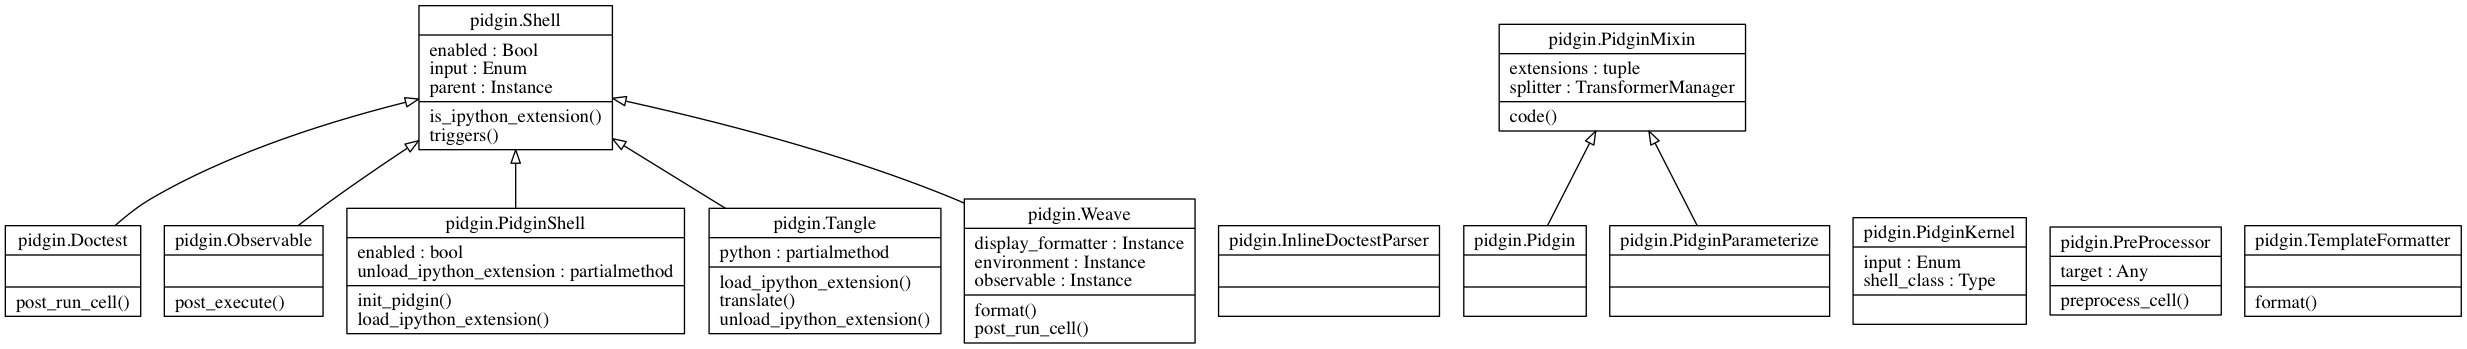

if _run_as_interactive:
        !jupyter nbconvert --to python --TemplateExporter.exclude_input_prompt=True pidgin.ipynb
        !isort pidgin.py
        !black pidgin.py
        !pyflakes pidgin.py && echo "🏋️‍♀️"
        !pyreverse -my -opng  -ppidgin pidgin
        IPython.display.display(IPython.display.Image('classes_pidgin.png', embed=True))

In [20]:
    if _run_as_interactive:
        !jupyter nbconvert --to python --TemplateExporter.exclude_input_prompt=True pidgin.ipynb
        !isort pidgin.py
        !black pidgin.py
        !pyflakes pidgin.py && echo "🏋️‍♀️"
        !pyreverse -my -opng  -ppidgin pidgin
        IPython.display.display(IPython.display.Image('classes_pidgin.png', embed=True))